# Libraries IPyStata and Data Import

We import the libraries necessary for the analysis and the Stata Python Magic [*IPyStata*](https://github.com/TiesdeKok/ipystata), that allows us to use both Python and Stata in a single notebook, thereby taking advantage of Python libraries to do the preprocessing and plot some graphs for the EDA (Exploratory Data Analysis) and of Stata functions to easily estimate and compare the econometric models. The two environments communicate between each other by importing/exporting Pandas `DataFrame` objects.

In [1]:
import ipystata
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

IPyStata is loaded in batch mode.


In [2]:
from ipystata.config import config_stata

Change the directory below with your own Stata directory.

In [3]:
config_stata('/Applications/Stata/StataSE.app/Contents/MacOS/stataSE')

We check that the notebook correctly interacts with Stata.

In [4]:
%%stata 

display "Hello, I am printed in Stata." 


Hello, I am printed in Stata.


In [5]:
path = os.getcwd()

In [6]:
data = pd.read_stata(path + "/Marketing Insight.dta")

In [7]:
len(data)

15288

In [8]:
data.head()

,id,year,assets,debt,profit,profit_cash,sales,ad,rd,firmrisk,fv,mkt,sector
0,685.0,2000-01-01,52.744,0.000,-11.597,-10.712,25.213,2.824,17.240999,0.060656,5.164540,15.471001,1.0
1,1546.0,2000-01-01,11.714,0.950,-7.891,-7.059,10.439,0.733,4.003000,0.091056,1.296880,8.812000,1.0
2,1565.0,2000-01-01,10.352,2.880,-5.255,-3.234,8.769,0.014,3.770000,0.072004,1.835298,4.310000,1.0
3,1611.0,2000-01-01,4149.000,2397.000,1193.000,491.000,7093.000,325.000,24.000000,0.028016,1.749337,554.000000,6.0
4,561.0,2000-01-01,320.293,130.276,45.716,27.521,348.733,3.000,3.300000,0.048150,0.881263,47.832001,1.0


In [9]:
data.describe()

,id,assets,debt,profit,profit_cash,sales,ad,rd,firmrisk,fv,mkt,sector
count,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000
mean,1347.099032,4476.234501,859.191887,665.471554,537.290300,3846.902561,93.729088,159.094467,0.034953,1.898294,695.238037,2.066392
std,741.525833,20442.022529,4242.984755,3029.074140,2603.680451,17958.026135,415.836853,777.747314,0.025262,2.533227,3106.363525,1.426456
min,1.000000,0.179000,0.000000,-2439.943000,-3703.000000,0.000000,0.000000,0.000000,0.002053,0.003286,-1895.591064,1.000000
25%,735.000000,82.680750,0.000000,1.089000,0.645750,71.165250,0.538000,0.500000,0.019447,0.854192,21.370001,1.000000
50%,1305.000000,313.849000,4.498500,26.882500,22.104500,301.820000,3.400000,7.305500,0.028078,1.383479,71.304501,1.000000
75%,1991.000000,1460.707750,204.212000,182.061750,143.361000,1357.295500,25.600000,39.698750,0.042513,2.270785,277.000000,3.000000
max,2687.000000,421879.000000,118515.000000,81730.000000,81266.000000,483521.000000,9729.000000,12540.000000,0.533140,203.297607,94415.000000,6.000000


# Preliminary preprocessing

In this part, we perform some preliminary preprocessing to fix some bugs obtained by loading the `.dta` dataset into a Pandas `DataFrame` and to isolate just the data we are interested in.

We check if all the date values of the `year` column contain "01-01" (1st January).

In [10]:
days_not1 = 0
month_not1 = 0

for i in range(len(data)):
     day = data.iloc[i,1].date().day
     month = data.iloc[i,1].date().month
     if day != 1:
         days_not1 += 1
     if month != 1:
         months_not1 += 1

print(days_not1, month_not1)

0 0


We convert all the dates to simple integers representing the year related to each instance, otherwise we will get problems in estimating the models using Stata.

In [11]:
data['year'] = data['year'].apply(lambda x: x.date().year)

type(data.loc[0, "year"])

numpy.int64

We filter the data by the chosen sector and save them into another Pandas `DataFrame`. \
We choose the retailing sector, represented by the value 2 of the variable sector.

In [12]:
chosen_sector = 2

retail_df = data[data['sector']==chosen_sector].reset_index().drop(columns=['sector', 'index'])

retail_df.head()

,id,year,assets,debt,profit,profit_cash,sales,ad,rd,firmrisk,fv,mkt
0,1405.0,2000,106.557,5.111,9.773,34.063,317.879,1.254000,0.0,0.052853,0.459979,68.063004
1,1388.0,2000,170.002,33.000,33.877,12.266,281.471,2.296000,0.0,0.026660,1.174727,61.759998
2,93.0,2000,2583.019,686.857,348.485,202.217,3724.778,499.372986,0.0,0.043163,0.527770,1065.524048
3,2.0,2000,13.413,0.949,1.104,2.731,25.521,0.439000,0.0,0.042102,3.288638,5.028000
4,1622.0,2000,49.932,15.864,-3.605,-5.628,44.426,11.023000,0.0,0.130628,0.776852,13.964001


# Variable construction

Let $\text{Firms}_t$ be the set of firms in retailing sector in year $t$ and $\text{Years}=\{2000, ...,2015\}$.

#### *Total Sales* in each year

We compute the number of firms competing in the market and the total sales in the retailing sector for each year.

$$ \text{tsales}_{i\bar{t}} = \sum_{i \in \text{Firms}_\bar{t}}\text{sales}_{i\bar{t}} $$
for any $i \in \text{Firms}_\bar{t}$, for any $\bar{t} \in \text{Years}$. \
It is easy to see that for any $\bar{t} \in \text{Years}$, we have $ \text{tsales}_{i\bar{t}} = \text{tsales}_{i'\bar{t}}$ for any $i,i' \in \text{Firms}_\bar{t}$.

In [13]:
%%stata -d retail_df -o retail_df

gen nfirm=1
by year, sort: egen numfirm=sum(nfirm)
by year, sort: egen tsales=sum(sales)

#### *Total Profit* in each year

We compute the total profit in the retailing sector for each year.

$$ \text{tprofit}_{i\bar{t}} = \sum_{i \in \text{Firms}_\bar{t}}\text{profit}_{i\bar{t}} $$
for any $i \in \text{Firms}_\bar{t}$, for any $\bar{t} \in \text{Years}$. \
It is easy to see that for any $\bar{t} \in \text{Years}$, we have $ \text{tprofit}_{i\bar{t}} = \text{tprofit}_{i'\bar{t}}$ for any $i,i' \in \text{Firms}_\bar{t}$.

In [14]:
%%stata -d retail_df -o retail_df

by year, sort: egen tprofit=sum(profit)

#### *Market Share* for each firm in each year

We compute the market_share of each firm in each year.

$$ \text{market_share}_{it} = \dfrac{\text{sales}_{it}}{\text{tsales}_{it}} $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.

In [15]:
%%stata -d retail_df -o retail_df

gen market_share=sales/tsales

#### *Herfindahl-Hirschman index (HHI)* in each year

We compute the HHI in each year.

$$ \text{hhi}_{i\bar{t}} = \sum_{i \in \text{Firms}_\bar{t}}(\text{market_share}_{i\bar{t}}\cdot 100)^2 $$
for any $i \in \text{Firms}_\bar{t}$, for any $\bar{t} \in \text{Years}$. \
It is easy to see that for any $\bar{t} \in \text{Years}$, we have $ \text{hhi}_{i\bar{t}} = \text{hhi}_{i'\bar{t}}$ for any $i,i' \in \text{Firms}_\bar{t}$.

In [16]:
%%stata -d retail_df -o retail_df

by year, sort: egen hhi=sum((market_share*100)^2)

#### *Firm Size* for each firm in each year

We decided to use the logarithm of the variable `sales` to measure the firm size.

$$ \text{firmsize}_{it} = \log(\text{sales}_{it}) $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.

In [17]:
%%stata -d retail_df -o retail_df

gen firmsize = log(sales)

#### *Market Growth*  in each year

We compute the industry-wide one-year market growth in each year.

$$ \text{mkgrowth}_{i\bar{t}} = \log(\text{tsales}_{i,\bar{t}}) - \log(\text{tsales}_{i,\bar{t}-1}) $$
for any $i \in \text{Firms}_\bar{t}$, for any $\bar{t} \in \text{Years}$. \
It is easy to see that for any $\bar{t} \in \text{Years}$, we have $ \text{mkgrowth}_{i\bar{t}} = \text{mkgrowth}_{i'\bar{t}}$ for any $i,i' \in \text{Firms}_\bar{t}$.

We build an auxiliary `DataFrame` where we can store year-dependent variables, constant for all the firms in a given year, used to compute the industry-wide market growth from one year to the following one using Python. We noted that in this way we would not lose unnecessary missing values that would be created by using the Stata code commented out below.

In [18]:
aux_data = pd.DataFrame(retail_df[['year','tsales','hhi','numfirm','tprofit']].drop_duplicates()).set_index('year')

for i in range(2001, 2016):
    aux_data.loc[i,'mkgrowth'] = np.log(aux_data.loc[i,'tsales']) - np.log(aux_data.loc[i-1,'tsales'])

# The non-missing data are the same as those from the following Stata commands:
# With these commands we also add lagtsales to the df, which has not been done with pandas above

# %%stata -d retail_df -o retail_df
# xtset id year
# gen Lagtsales=l.tsales

# %%stata -d retail_df -o retail_df
# gen mkgrowth=log(tsales)-log(Lagtsales)

aux_data.head()

,tsales,hhi,numfirm,tprofit,mkgrowth
year,,,,,
2000,557841.1250,1380.064331,148.0,39183.750000,NaN
2001,744859.0625,1066.669312,146.0,48995.058594,0.289121
2002,832427.1250,1055.974365,152.0,61110.718750,0.111151
2003,887526.7500,1042.804199,152.0,73026.007812,0.064093
2004,953368.1250,1100.188110,140.0,79147.914062,0.071563


In [19]:
for i in range(len(retail_df)):
    retail_df.loc[i,'mkgrowth'] = aux_data.loc[retail_df.loc[i,'year'],'mkgrowth']

In [20]:
retail_df['mkgrowth'].isnull().sum()

148

The new method leads to a lower number of NaNs (missing values) of 148 instead of 314 (which is what we obtained with the Stata commands).

#### *Strategic Emphasis (SE)*  for each firm in each year

We compute a variable measuring strategic emphasis (SE), i.e. the extent to which a firm allocates its resources in brand building (i.e., advertising) compared to innovation (i.e., R&D).

$$ \text{s_emphasis}_{it} = \dfrac{\text{ad}_{it}-\text{rd}_{it}}{\text{assets}_{it}} $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.

In [21]:
%%stata -d retail_df -o retail_df

gen s_emphasis = (ad-rd)/assets

#### *Advertising Intensity*, *Marketing Intensity* and *R&D Intensity* for each firm in each year

We compute advertising intensity, marketing intensity and R&D intensity. Since the advertising spending, marketing spending and R&D spending have the same scale as the variable `sales`, we do not use their absolute levels and not their log-transformation.

$$ \text{ad_intensity}_{it} = \dfrac{\text{ad}_{it}}{\text{sales}_{it}} $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.
$$ \text{mkt_intensity}_{it} = \dfrac{\text{mkt}_{it}}{\text{sales}_{it}} $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.
$$ \text{rd_intensity}_{it} = \dfrac{\text{rd}_{it}}{\text{sales}_{it}} $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.

In [22]:
%%stata -d retail_df -o retail_df

gen ad_intensity = ad/sales
gen mkt_intensity = mkt/sales
gen rd_intensity = rd/sales

#### *Leverage Ratio (proxy)* for each firm in each year

We compute a variant of the leverage ratio, i.e. a proxy for total-debt-to-total-assets ratio, since the variable `debt` in the dataset indicates the long term debt of each firm in each year.

$$ \text{leverage}_{it} = \dfrac{\text{debt}_{it}}{\text{assets}_{it}} $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.

In [23]:
%%stata -d retail_df -o retail_df

gen leverage = debt/assets

**N.B.: manca il Beta del CAPM**

retail_df.head()

#### *Firm Growth* for each firm in each year

We measure the one-year firm growth for each firm in each year by computing the one-year variation in the log-levels of the `sales` variable.

$$ \text{firm_growth_sales}_{it} = \log(\text{sales}_{i,t}) - \log(\text{sales}_{i,t-1}) $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.

To take into account the fact that not all the companies compete in the retailing sector in all the years from 2000 to 2015, for any year, we create an axiliary `DataFrame` object having as dimensions firm id in each row and sales in each year. It is initialized to all NaNs and then filled by searching for the necessary values in the original dataset.

In [24]:
print('Numero di aziende presenti nel dataset: '+ str(len(retail_df['id'].unique())))

Numero di aziende presenti nel dataset: 288


In [25]:
companies_df_sales = pd.DataFrame(np.nan, index=retail_df['id'].unique().astype('int64'),columns=[i for i in range(2000,2016)]).sort_index()

for firm in companies_df_sales.index:
    year_sales_df = pd.DataFrame(retail_df[retail_df['id']==firm][['year','sales']].set_index('year'))
    for year in year_sales_df.index:
        companies_df_sales.loc[firm, year] = year_sales_df.loc[year,'sales']

In [26]:
companies_df_sales.head(3)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
2,25.521,21.117,22.02,26.209,28.642,35.64,44.083,62.967,105.219,85.37,82.568,149.627,127.877,108.542,70.743,60.918
3,860.543,NaN,749.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,713.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,805.156


We check that the missing values in the two matrices are due to the same firms and years. Thus, we can use the same 'id' and 'year' indexes to get the values from both matrices for the same firm in the same year.

In [27]:
print('Missing records for sales: ' + str(companies_df_sales.isnull().sum().sum()))
print('Total records for sales: '+ str(288*16) + '\n')

Missing records for sales: 2554
Total records for sales: 4608



aggiungere descrizione

In [28]:
for firm in companies_df_sales.index:
    year_sales_df = pd.DataFrame(retail_df[retail_df['id']==firm][['year','sales']].set_index('year'))
    # As explained above, where we obtain the indexes from is not relevant
    for year in np.delete(year_sales_df.index,0):
        if year == year_sales_df.index[1]:
            prev_year = year_sales_df.index[0]
        else:
            prev_year = year - 1
        # We add a try-except statament to take into account non-consecutive years of activiy of a firm.
        # When considering sales in year t, if sales in year t-1 are not in the dataset,
        #   then the corresponding market growth from t-1 to t is left to NaN
        try:
            retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
        except:
            retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.nan

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retail_df.loc[retail_df[retail_df['id']==firm][retail_df['year']==year].index[0], 'firm_growth_sales'] = np.log(year_sales_df.loc[year,'sales']) - np.log(year_sales_df.loc[prev_year,'sales'])
<ipython-input-28-07d87d77942d>:13: UserWarning: Boolean Series key will be reinde

In [29]:
print('Number of total records: ' + str(retail_df['firm_growth_sales'].count() + retail_df['firm_growth_sales'].isnull().sum()))
print('Number of present values: ' + str(retail_df['firm_growth_sales'].count()))
print('Number of missing values: ' + str(retail_df['firm_growth_sales'].isnull().sum()))

Number of total records: 2054
Number of present values: 1750
Number of missing values: 304


In [30]:
retail_df

,id,year,assets,debt,profit,profit_cash,sales,ad,rd,firmrisk,...,market_share,hhi,firmsize,mkgrowth,s_emphasis,ad_intensity,mkt_intensity,rd_intensity,leverage,firm_growth_sales
0,1804.0,2000,243.147,166.206,68.176,2.386,586.867,27.580999,0.000,0.061175,...,0.001052,1380.064331,6.374798,NaN,0.113433,0.046997,0.181441,0.000000,0.683562,NaN
1,1667.0,2000,335.128,97.705,41.292,24.053,751.124,17.284000,0.000,0.044983,...,0.001346,1380.064331,6.621571,NaN,0.051574,0.023011,0.196434,0.000000,0.291545,NaN
2,1462.0,2000,7.559,0.463,1.169,0.519,9.629,0.175000,0.000,0.185686,...,0.000017,1380.064331,2.264779,NaN,0.023151,0.018174,0.566622,0.000000,0.061251,NaN
3,886.0,2000,908.009,326.449,21.910,-114.717,2227.599,78.223999,0.000,0.040059,...,0.003993,1380.064331,7.708680,NaN,0.086149,0.035116,0.353481,0.000000,0.359522,NaN
4,1939.0,2000,16.839,0.000,-28.106,-28.523,34.257,11.100000,7.951,0.124639,...,0.000061,1380.064331,3.533891,NaN,0.187006,0.324021,0.646875,0.232099,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,1209.0,2015,433.902,44.425,69.131,17.468,1583.789,11.121000,0.000,0.018579,...,0.000969,1133.081909,7.367575,0.032539,0.025630,0.007022,0.222797,0.000000,0.102385,0.042008
2050,755.0,2015,42549.000,20888.000,13592.000,9373.000,88519.000,868.000000,0.000,0.008636,...,0.054134,1133.081909,11.390972,0.032539,0.020400,0.009806,0.178549,0.000000,0.490916,0.062258
2051,663.0,2015,819.191,200.255,126.152,164.047,1892.230,66.289001,0.000,0.032399,...,0.001157,1133.081909,7.545511,0.032539,0.080920,0.035032,0.270865,0.000000,0.244455,0.014076
2052,2388.0,2015,314.508,0.000,41.894,27.488,683.791,2.600000,0.000,0.027121,...,0.000418,1133.081909,6.527652,0.032539,0.008267,0.003802,0.325418,0.000000,0.000000,0.019122


#### *Marketing Lagged Variables* for each firm in each year

Being `mkt` our focal variable, we compute the 1-year, 2-year and 3-year marketing spending (`mkt`) lagged variables in order to incorporate marketing lagged effects in our models. \
Some NaNs will be generated since the not all companies compete in the retailing sector in all the years.

$$ \text{lag_mkt_1}_{it} = \text{mkt}_{i,t-1} $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.
$$ \text{lag_mkt_2}_{it} = \text{mkt}_{i,t-2} $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.
$$ \text{lag_mkt_3}_{it} = \text{mkt}_{i,t-3} $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.

In [31]:
%%stata -d retail_df -o retail_df

xtset id year
gen lag_mkt_1 = l.mkt
gen lag_mkt_2 = l2.mkt
gen lag_mkt_3 = l3.mkt


       panel variable:  id (unbalanced)
        time variable:  year, 2000 to 2015, but with gaps
                delta:  1 unit
(314 missing values generated)
(561 missing values generated)
(779 missing values generated)


#### *3-year Marketing Growth* for each firm in each year

We compute the 3-year average growth in the marketing spending variable (`mkt`), since it can potentially be less problematic then the lagged variables in terms of multicollinearity.

$$ \text{mkt_growth}_{it} = \dfrac{\text{mkt}_{i,t}-\text{mkt}_{i,t-3}}{\text{mkt}_{i,t-3}} $$
for any $i \in \text{Firms}_t$, for any $t \in \text{Years}$.

In [32]:
%%stata -d retail_df -o retail_df

gen mkt_growth = (mkt-lag_mkt_3)/lag_mkt_3


(779 missing values generated)


In [33]:
retail_df.to_stata('Data_sector_2.dta')

# Descriptive statistics and graphs

In [34]:
# for i in retail_df.drop(["year","id", "nfirm", "fv", "numfirm"], axis=1):
#     retail_df.plot.scatter(i,"fv", logy = True, figsize= (15,5))

# for i in retail_df.drop(["year","id", "nfirm", "fv", "numfirm"], axis=1):
#     retail_df.boxplot(i, figsize= (15,5), vert = False)
#     plt.show()

In [35]:
r_1, r_2, r_3, r_4 = retail_df[2000<=retail_df['year']][retail_df['year']<2004].copy(), retail_df[2004<=retail_df['year']][retail_df['year']<2008].copy(), retail_df[2008<=retail_df['year']][retail_df['year']<2012].copy(), retail_df[2012<=retail_df['year']][retail_df['year']<2016].copy()

<ipython-input-35-6c989729d2fa>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_1, r_2, r_3, r_4 = retail_df[2000<=retail_df['year']][retail_df['year']<2004].copy(), retail_df[2004<=retail_df['year']][retail_df['year']<2008].copy(), retail_df[2008<=retail_df['year']][retail_df['year']<2012].copy(), retail_df[2012<=retail_df['year']][retail_df['year']<2016].copy()
<ipython-input-35-6c989729d2fa>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_1, r_2, r_3, r_4 = retail_df[2000<=retail_df['year']][retail_df['year']<2004].copy(), retail_df[2004<=retail_df['year']][retail_df['year']<2008].copy(), retail_df[2008<=retail_df['year']][retail_df['year']<2012].copy(), retail_df[2012<=retail_df['year']][retail_df['year']<2016].copy()
<ipython-input-35-6c989729d2fa>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_1, r_2, r_3, r_4 = retail_df[2000<=retail_df['year']][retail_df['year']<2004].copy(

In [36]:
# r_1.to_stata('r_1.dta')
# r_2.to_stata('r_2.dta')
# r_3.to_stata('r_3.dta')
# r_4.to_stata('r_4.dta')

In [37]:
# %%stata -d r_1

# sum fv mkt ad rd sales profit leverage market_share

# count if mkt==0
# count if ad==0
# count if rd==0

After filtering the dataset, isolating the data about the retailing sector (2054 observations, accounting for 13.43% of the original dataset), we split the observations in four 4-year periods from 2000 to 2015 and separately computed univariate descriptive statistics, in order to focus on trends on both the cross-sectional and the time-series components of the panel data. \
We noticed that the number of observations vary across the four time periods, thereby indicating the presence of an unbalanced panel, i.e. a dataset in which at least one experimental unit is not observed every period. \
All the firms in the sample have positive marketing spending and advertising spending over all periods expect the first period, in which however a very small percentage of firms (0.33%) presents zero advertising spending. \
The opposite trend is observed in the case of R&D spending: the vast majority of firms have zero R&D spending (95.35% on average) and the proportion of such firms increased over time (from 93.98% in the 2000-2003 period to 97.32% in the 2012-2015 period). \
This result clearly evidences that retailing firms do not distribute their resources equally between marketing/advertising and R&D, but have a strong inclination to invest in marketing and advertising activities. \
As for the variable we want to explain, i.e. firm value (`fv`), the mean and minimum value are quite similar over the four time periods, whereas the maximum value in the first period is much higher than the corresponding values in the subsequent periods, and naturally also the standard deviation is substantially higher in the first period than in the others (approximately 8 times higher), given the similarity in the means and minimum values in the four subsamples. \
This clearly emphasizes the presence of one or a few outliers from 2000 to 2003. \
The focal variable, i.e. marketing spending (`mkt`), shows positive trends in the mean, standard deviation and maximum value, pointing out that the amounts spent on marketing activities by the retailing firms are more spread apart, where the dispersion is mainly driven by the fact that some firms are investing substantially more than others, even though also the negative minimum values in the first two periods make a contribution. However, without further explanation about the data, it is difficult to interpret the nature of these negative values, i.e. whether they are due to errors in data recording or might offer a meaningful insight.

In [38]:
aux_data.head()

,tsales,hhi,numfirm,tprofit,mkgrowth
year,,,,,
2000,557841.1250,1380.064331,148.0,39183.750000,NaN
2001,744859.0625,1066.669312,146.0,48995.058594,0.289121
2002,832427.1250,1055.974365,152.0,61110.718750,0.111151
2003,887526.7500,1042.804199,152.0,73026.007812,0.064093
2004,953368.1250,1100.188110,140.0,79147.914062,0.071563


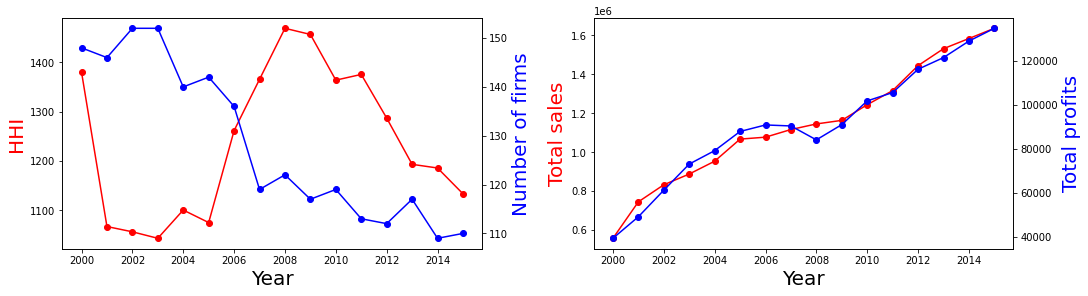

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4), constrained_layout=True)

ax1.plot(aux_data.index.tolist(), aux_data['hhi'].tolist(), color="red", marker="o")
ax1.set_xlabel("Year",fontsize=20)
ax1.set_ylabel("HHI",color="red",fontsize=20)
ax3=ax1.twinx()
ax3.plot(aux_data.index.tolist(), aux_data['numfirm'].tolist(), color="blue", marker="o")
ax3.set_ylabel("Number of firms",color="blue",fontsize=20)

ax2.plot(aux_data.index.tolist(), aux_data['tsales'].tolist(), color="red", marker="o")
ax2.set_xlabel("Year",fontsize=20)
ax2.set_ylabel("Total sales",color="red",fontsize=20)
ax4=ax2.twinx()
ax4.plot(aux_data.index.tolist(), aux_data['tprofit'].tolist(), color="blue", marker="o")
ax4.set_ylabel("Total profits",color="blue",fontsize=20)
plt.show()

From the graphs above/below we can easily note that the number of firm competing in the industry has been decreasing over time: in particular we observe a steady drop from the years 2005 to 2008, while during the same time interval the HHI index significantly increased above 1500, before decreasing again to a level between 1100 and 1200, which accounts for a very competitive market.\
Furthermore, we observe that the total sales of the firms in the industry have been increasing quite linearly over time, and the same can be said about the their total profits with the exception of two years.\
However, the shrinkages observed from 2007 to 2009 might not prove to be good indicators for some trends in the industry, since this period corresponds to that of the global financial crisis which of course affected firms' activities worldwide and not just in this specific sector.

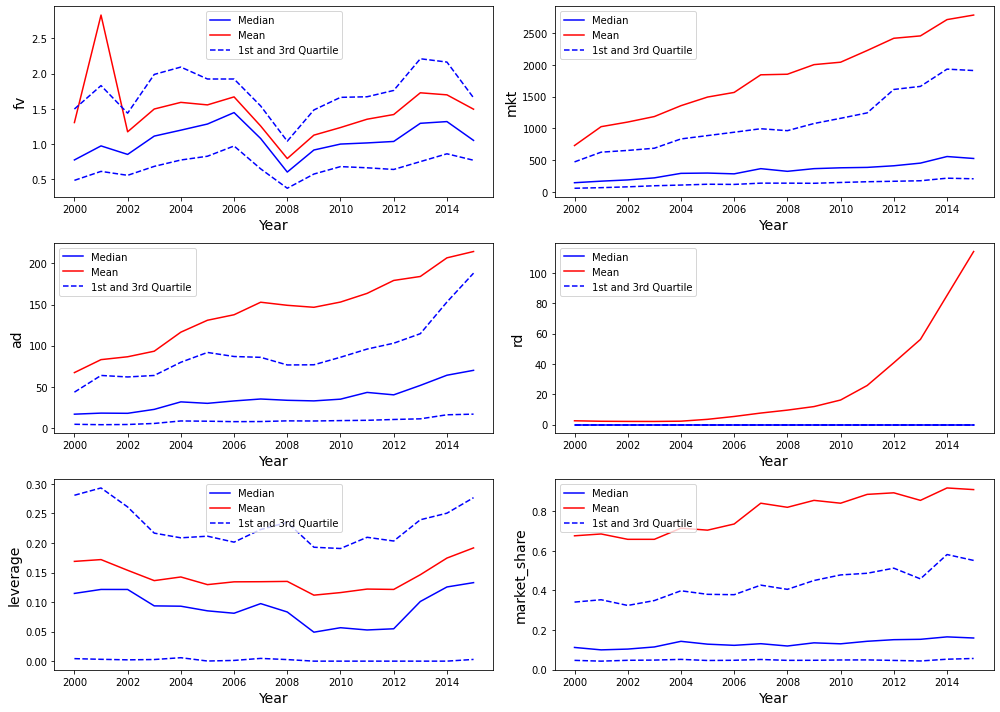

In [40]:
plt.figure(figsize=(14,10), tight_layout=True)

medians_fv = [np.median(retail_df[retail_df['year']==year]['fv']) for year in aux_data.index.tolist()]
medians_mkt = [np.median(retail_df[retail_df['year']==year]['mkt']) for year in aux_data.index.tolist()]
medians_ad = [np.median(retail_df[retail_df['year']==year]['ad']) for year in aux_data.index.tolist()]
medians_rd = [np.median(retail_df[retail_df['year']==year]['rd']) for year in aux_data.index.tolist()]
medians_leverage = [np.median(retail_df[retail_df['year']==year]['leverage']) for year in aux_data.index.tolist()]
medians_market_share = [100*np.median(retail_df[retail_df['year']==year]['market_share']) for year in aux_data.index.tolist()]

q1_fv = [np.quantile(retail_df[retail_df['year']==year]['fv'], 0.25) for year in aux_data.index.tolist()]
q1_mkt = [np.quantile(retail_df[retail_df['year']==year]['mkt'], 0.25) for year in aux_data.index.tolist()]
q1_ad = [np.quantile(retail_df[retail_df['year']==year]['ad'], 0.25) for year in aux_data.index.tolist()]
q1_rd = [np.quantile(retail_df[retail_df['year']==year]['rd'], 0.25) for year in aux_data.index.tolist()]
q1_leverage = [np.quantile(retail_df[retail_df['year']==year]['leverage'], 0.25) for year in aux_data.index.tolist()]
q1_market_share = [100*np.quantile(retail_df[retail_df['year']==year]['market_share'], 0.25) for year in aux_data.index.tolist()]

q3_fv = [np.quantile(retail_df[retail_df['year']==year]['fv'], 0.75) for year in aux_data.index.tolist()]
q3_mkt = [np.quantile(retail_df[retail_df['year']==year]['mkt'], 0.75) for year in aux_data.index.tolist()]
q3_ad = [np.quantile(retail_df[retail_df['year']==year]['ad'], 0.75) for year in aux_data.index.tolist()]
q3_rd = [np.quantile(retail_df[retail_df['year']==year]['rd'], 0.75) for year in aux_data.index.tolist()]
q3_leverage = [np.quantile(retail_df[retail_df['year']==year]['leverage'], 0.75) for year in aux_data.index.tolist()]
q3_market_share = [100*np.quantile(retail_df[retail_df['year']==year]['market_share'], 0.75) for year in aux_data.index.tolist()]

means_fv = [np.mean(retail_df[retail_df['year']==year]['fv']) for year in aux_data.index.tolist()]
means_mkt = [np.mean(retail_df[retail_df['year']==year]['mkt']) for year in aux_data.index.tolist()]
means_ad = [np.mean(retail_df[retail_df['year']==year]['ad']) for year in aux_data.index.tolist()]
means_rd = [np.mean(retail_df[retail_df['year']==year]['rd']) for year in aux_data.index.tolist()]
means_leverage = [np.mean(retail_df[retail_df['year']==year]['leverage']) for year in aux_data.index.tolist()]
means_market_share = [100*np.mean(retail_df[retail_df['year']==year]['market_share']) for year in aux_data.index.tolist()]

plt.subplot(321)
plt.plot(aux_data.index.tolist(), medians_fv, '-', c='b', label='Median')
plt.plot(aux_data.index.tolist(), means_fv, '-', c='r', label='Mean')
plt.plot(aux_data.index.tolist(), q1_fv, '--', c='b', label='1st and 3rd Quartile')
plt.plot(aux_data.index.tolist(), q3_fv, '--', c='b')
plt.xlabel('Year', fontsize=14)
plt.ylabel('fv', fontsize=14)
plt.legend()

plt.subplot(322)
plt.plot(aux_data.index.tolist(), medians_mkt, '-', c='b', label='Median')
plt.plot(aux_data.index.tolist(), means_mkt, '-', c='r', label='Mean')
plt.plot(aux_data.index.tolist(), q1_mkt, '--', c='b', label='1st and 3rd Quartile')
plt.plot(aux_data.index.tolist(), q3_mkt, '--', c='b')
plt.xlabel('Year', fontsize=14)
plt.ylabel('mkt', fontsize=14)
plt.legend()

plt.subplot(323)
plt.plot(aux_data.index.tolist(), medians_ad, '-', c='b', label='Median')
plt.plot(aux_data.index.tolist(), means_ad, '-', c='r', label='Mean')
plt.plot(aux_data.index.tolist(), q1_ad, '--', c='b', label='1st and 3rd Quartile')
plt.plot(aux_data.index.tolist(), q3_ad, '--', c='b')
plt.xlabel('Year', fontsize=14)
plt.ylabel('ad', fontsize=14)
plt.legend()

plt.subplot(324)
plt.plot(aux_data.index.tolist(), medians_rd, '-', c='b', label='Median')
plt.plot(aux_data.index.tolist(), means_rd, '-', c='r', label='Mean')
plt.plot(aux_data.index.tolist(), q1_rd, '--', c='b', label='1st and 3rd Quartile')
plt.plot(aux_data.index.tolist(), q3_rd, '--', c='b')
plt.xlabel('Year', fontsize=14)
plt.ylabel('rd', fontsize=14)
plt.legend()

plt.subplot(325)
plt.plot(aux_data.index.tolist(), medians_leverage, '-', c='b', label='Median')
plt.plot(aux_data.index.tolist(), means_leverage, '-', c='r', label='Mean')
plt.plot(aux_data.index.tolist(), q1_leverage, '--', c='b', label='1st and 3rd Quartile')
plt.plot(aux_data.index.tolist(), q3_leverage, '--', c='b')
plt.xlabel('Year', fontsize=14)
plt.ylabel('leverage', fontsize=14)
plt.legend()

plt.subplot(326)
plt.plot(aux_data.index.tolist(), medians_market_share, '-', c='b', label='Median')
plt.plot(aux_data.index.tolist(), means_market_share, '-', c='r', label='Mean')
plt.plot(aux_data.index.tolist(), q1_market_share, '--', c='b', label='1st and 3rd Quartile')
plt.plot(aux_data.index.tolist(), q3_market_share, '--', c='b')
plt.xlabel('Year', fontsize=14)
plt.ylabel('market_share', fontsize=14)
plt.legend()

We decided to compare the median and the mean of some variables of interest in order to identify some trends in the industry and to be able to detect the presence of outliers which may potentially influence our final results. Therefore, in the following graphs we decided to plot the value of these two measurements together with the values of the first and the third quartiles for each year, so that the reader might easily visualize the inter-quartile range and understand how much spread the data is.\
We observe that:
* firm value (`fv`) has actually been slightly growing over time, with the except of a drop probably due to the global financial crisis, and in the end just increased a little on average from 2000 and 2015. We also note an unusually high mean value in 2001, which is not reflected in the median and is thus likely to indicate the entrance in the market of one or few very valuable competitors, which however seem to have quickly abandoned the competition. Another plausible explanation for this outlier could be related to an issue in the recording of data.
* marketing expenses (`mkt`) have increased over time and the gap between the first and the third quartile has widened, indicating that different firms have different beliefs on how much of their budget they should allocate to these operations. Moreover, we can notice that throughout the period the mean is significantly higher than the median and the third quartile, thereby indicating a skewed distribution.
* advertising spending (`adv`) have also been growing quite linearly over time, and during the last years firms seem to have allocated more and more resoruces to these operations, as it can be oberved by the steady increase in the values of the third quartile. As before, being the mean substantially higher than the median and the third quartile, we can notice the presence of a skewed distribution.
* research and development (`rd`) does not seem to play a crucial role in this industry: in fact, the median of this measure is zero in all years, while there has been a steady increase in the mean over time. Therefore, we might suppose that there are few firms that are  increasing their investing activities in R&D so much as to drive the mean significantly further away from the median in each year, and this is in fact confirmed by a closer observation of the data, which reveals that over 90% of the firms are in fact not investing in R&D while in 2015 there was a single firm investing over \\$12,000 million in this field (and only another firm investing more than \\$1 million).
* leverage ratio (`leverage`) has been slightly decreasing before the financial crisis and slightly growing after that period. Furthermore, the values seem quite spread between the firms and there is not a clear trend which might help us to  predict whether in the future it will increase, decrease or stay constant.
* market share (`market_share`) in percentage is lower than 0.6 for approximately 75% of the firms in all given years, whereas the mean is higher than this value, thereby indicating a skewed distribution.

In [41]:
experiment = retail_df.loc[(retail_df['year']==2015) & (retail_df['rd']>1)]
experiment

,id,year,assets,debt,profit,profit_cash,sales,ad,rd,firmrisk,...,s_emphasis,ad_intensity,mkt_intensity,rd_intensity,leverage,firm_growth_sales,lag_mkt_1,lag_mkt_2,lag_mkt_3,mkt_growth
1409,1569.0,2015,65444.000,14183.0,7304.000,11920.000,107006.000,3800.000,12540.0,0.017678,...,-0.133549,0.035512,0.155234,0.117190,0.21672,0.184383,13350.000000,10447.000000,7723.000000,1.150848
1983,2543.0,2015,240.719,0.0,-24.768,-22.333,47.546,2.204,1.5,0.511230,...,0.002925,0.046355,0.980629,0.031548,0.00000,-0.689597,66.594002,83.054001,75.117996,-0.379310
